This Julia jupyter notebook implement and test the TRG algorithm presented by Levin and Nave in 2007 on the square lattice Ising model with Periodic Boundary Conditions. 

The physicals quantites as the partition function, the Helmholtz free energy and the sponteanous magnetization are computed and compared with theoritical values.

Here the hamiltonian of the system is defined by : 

$ H = -J \sum_{<i,j>} \sigma_i \sigma_j - h \sum_{i}\sigma_i $

where :

$\sum_{<i,j>}$ means the sum over the nearest neighbors, 

$J$ is the coupling constant 

$h$ is the external field 

Hence, $J>0$ means that the system is ferromagnetic 

And $J<0$ means that the system is antiferromagnetic. 



## Packages

### Install packages

#### If you miss any package used in this jupyter notebook, you can install it by decomment the following cell:

In [21]:
#=
import Pkg
Pkg.add("MKL")
Pkg.add("ITensors")
Pkg.add("QuadGK")
Pkg.add("Printf")
Pkg.add("Plots")
Pkg.add("Measures")
Pkg.add("Zygote")
Pkg.add("FlexiMaps")
Pkg.add("Serialization")
Pkg.add("FiniteDifferences")
Pkg.add("JLD2")
=#

### Import packages

In [22]:
using MKL
using ITensors
ITensors.enable_debug_checks()
using QuadGK
using Printf
using Plots
using Measures
using Zygote
using FlexiMaps
using Serialization
using FiniteDifferences
using JLD2

## Constants

In [2]:
const kb  = 1.0

1.0

## Utils

In [70]:
function numerical_derivative(f, x, prec=1e-6, max_iter=1000)
    #=
        Compute the symmetric difference quotient of the function f at the point x. 
        It computes the quotient (f(x+h)-f(x-h))/2h for successive smaller and smaller h, 
        and stop when 2 successive quotients have a difference less than prec. 
    
        # Arguments
        - `f` : A function with a single argument.
        - `x` : The point at which the derivative of f will be computed.
        - `prec` : The prec which will tell the function when to stop.
        - `max_iter` : The maximal number of iteration that the function will do.
    
        # Returns
        - The symmetric difference quotient of the function f at the point x.
    =#
        h = min(1e-3, abs(x)/10)
        old_dev = (f(x + h) - f(x - h)) / (2h)
        new_dev = (f(x + 0.1*h) - f(x - 0.1*h)) / (2*0.1*h)
        diff = abs(old_dev - new_dev)
        nb_iter = 0
        while diff > prec && nb_iter < max_iter
            nb_iter += 1
            h *= 0.1
            old_dev = new_dev
            new_dev = (f(x + h) - f(x - h)) / (2h)
            diff = abs(old_dev - new_dev)
        end
        return new_dev
    end

function b_to_s(b)
    return 2*b - 1 # convert bit to spin: 0 -> -1, 1 -> 1
end

function get_spin(lattice::BitArray{2}, i, j)
    #=
        Return the spin value at position (i, j) in a 2D periodic Ising lattice with Periodic Boundary Conditions.
    
        Arguments:
        - `lattice::BitArray{2}`: A 2D array of Boolean values representing the spin configuration.
            - `false` (0) corresponds to spin down (−1)
            - `true` (1) corresponds to spin up (+1)
        - `i`, `j`: Integer coordinates (can be out of bounds), which will be wrapped using periodic boundary conditions.
    
        Returns:
        - The spin value at site `(i, j)`, mapped to −1 or +1 using the `b_to_s` conversion.
    
        Details:
        - Periodic boundary conditions are applied so that indexing wraps around the edges of the lattice.
        - The expression `(i-1) % L_h + 1` wraps `i` into the valid range `1:L_h`, and similarly for `j`.
    =#
        L_h, L_v = size(lattice)
        return b_to_s(lattice[(i-1)%L_h+1,(j-1)%L_v+1])
    end


get_spin (generic function with 1 method)

# Exact solution Square Lattice

Here are defined the exact values of the partition function, the Helmholtz free energy and the spontaneous magnetization of the square lattice Ising model with Periodic Boundary Conditions.

## 2 x 2 lattice

We start on the 2x2 square lattice with Periodic Boundary Conditions as a test in order to check the validity of the code on a small system. 

### Partition function Z

 partition function of the 2x2 square lattice Z(T=1, J=1.0, h=0.0) = 5973.916645008712


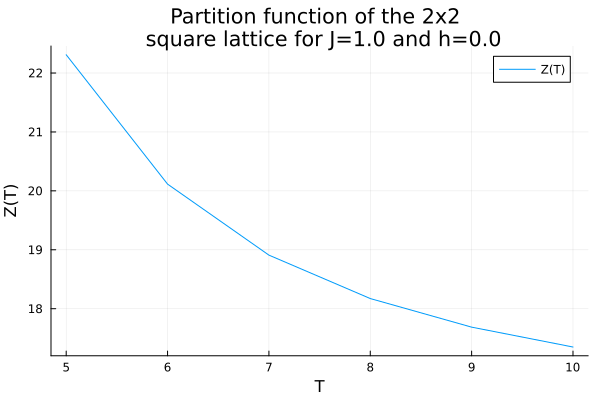

In [46]:
function H_2x2(i,j,k,l, J, h)
#=
    Compute the energy of a 2×2 Ising model configuration with periodic boundary conditions.

    # Arguments
    - `i, j, k, l` : Spin values represented by bits (1 or 2). Spin `s` is interpreted as `(-1)^s`,
    meaning:
        - If s = 1 → spin = 1 (up)
        - If s = 2 → spin = -1 (down)
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The total energy of the 2×2 lattice configuration.
=#
    return -J*(2*(-1)^i*(-1)^j + 2*(-1)^i*(-1)^k + 2*(-1)^l*(-1)^k + 2*(-1)^l*(-1)^j)-h*((-1)^i + (-1)^j + (-1)^k + (-1)^l)
end 

function Z_square_2x2(T, J, h)
#=
    Compute the partition function of a 2×2 Ising model with periodic boundary conditions.

    # Arguments
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The partition function of the 2×2 square lattice Ising model.
=#
    beta = 1.0/(kb*T)
    Z = 0 
    for i in 1:2, j in 1:2, k in 1:2, l in 1:2
        Z = Z + exp(-beta*H_2x2(i,j,k,l, J, h))
    end
    return Z
end

## Test 
T = 1
J= 1.0
h= 0.0

println(" partition function of the 2x2 square lattice Z(T=$T, J=$J, h=$h) = ", Z_square_2x2(T, J, h))

## Plot of the partition function as a function of the temperature

# Value of the model's parameters 
J= 1.0  # Coupling constant 
h= 0.0 # External field

# Temperature range
T_min = 5
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

y_Z = Z_square_2x2.(T_range, J, h)
plot(T_range, y_Z, 
    label="Z(T)", 
    title="Partition function of the 2x2 \n square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="Z(T)", 
    legend=:topright)

#savefig("partition_function_2x2.png")

### Free energy per site f

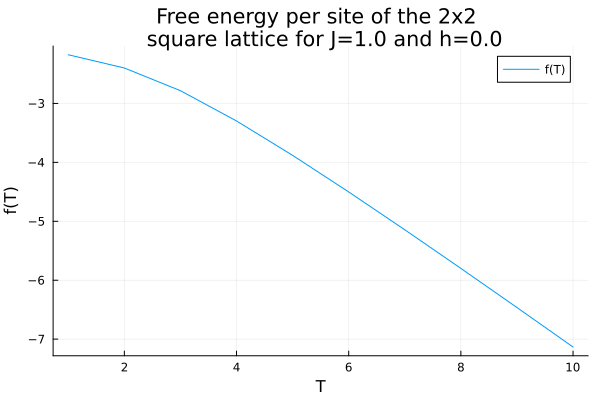

In [45]:
function free_energy_per_site_2x2(T, J, h)
#=
    Compute the free energy per site of a 2×2 Ising model with periodic boundary conditions.

    # Arguments
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The free energy per site of the 2×2 square lattice Ising model.
=#
    Z = Z_square_2x2(T, J, h)
    return -kb*T*log(Z)/4.0
end

## Plot of the free energy per site of the 2×2 square lattice Ising model as a function of the temperature

# Value of the model's parameters 
J= 1.0  # Coupling constant 
h= 0.0 # External field

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

y_f = free_energy_per_site_2x2.(T_range, J, h)
plot(T_range, y_f, 
    label="f(T)", 
    title="Free energy per site of the 2x2 \n square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="f(T)", 
    legend=:topright)

#savefig("free_energy_per_site_2x2.png")


### Magnetization

Here we compute the mean magnetization per site, i.e. the opposite of the derivative of the free energy per site with respect to the external field h.

$m = -\frac{\partial f}{\partial h}$

The spontaneous magnetization is defined as the magnetization of the system witout external field ($h=0$)

#### m(T)

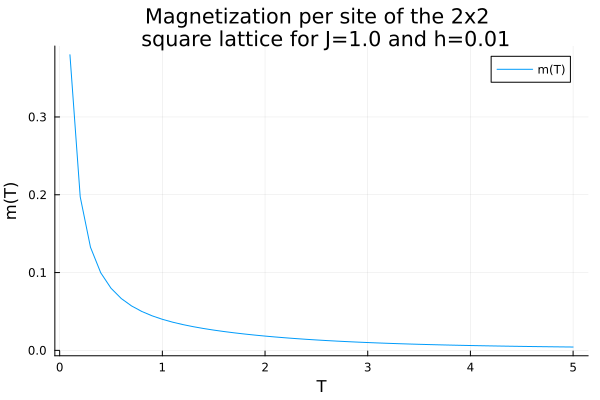

In [65]:
function magnetization_per_site_2x2(T, J, h)
#=
    Compute the mean magnetization per site of the 2x2 square lattice Ising model with periodic boundary conditions.

    # Arguments
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The mean magnetization of the 2×2 square lattice Ising model.
=#
    f(x) = free_energy_per_site_2x2(T, J, x)
    m = -numerical_derivative(f, h)
    return m
end

## Plot the mean magnetization per site of the 2x2 square lattice Ising model as a function of the temperature

# Value of the model's parameters
J= 1.0  # Coupling constant 
h= 0.01 # External field

# Temperature range
T_min = 0.1
T_max = 5
T_step = 0.1

T_range = T_min:T_step:T_max

y_m = magnetization_per_site_2x2.(T_range, J, h)
plot(T_range, y_m, 
    label="m(T)", 
    title="Magnetization per site of the 2x2 \n square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="m(T)", 
    legend=:topright)
#savefig("magnetization_per_site_2x2.png")


## $L_h \times L_v$ lattice

Here we define the exact physical quantities of the $L_h \times L_v$ square lattice with Periodic Boundary Conditions.

### Partition function Z

 partition function of the 2 x 2 square lattice Z(T=1, J=1.0, h=1) = 162843.487805491
Z_square(2, 2, 1, 1.0, 1) == Z_square_2x2(1, 1.0, 1) : true


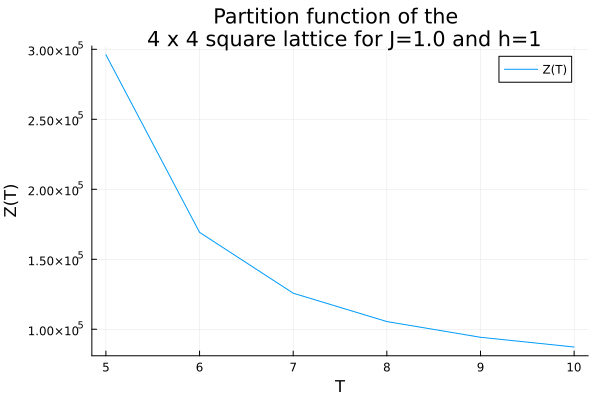

In [53]:
debug = false # plot informations in order to debug the code

function H(lattice::BitArray{2}, J, h)
#=
    Compute the energy of a L_h×L_v Ising model configuration with periodic boundary conditions.

    # Arguments
    - `lattice::BitArray{2}`: A 2D array of Boolean values representing the spin configuration.
            - `false` (0) corresponds to spin down (−1)
            - `true` (1) corresponds to spin up (+1)
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The total energy of the L_h×L_v lattice configuration.
=#
    L_h, L_v = size(lattice)
    p = 0 # sum of the product of all neighboring spins
    s = 0 # sum of the value of all the spins 
    for i in 1:L_h
        for j in 1:L_v
            p = p + get_spin(lattice,i,j)*get_spin(lattice,i+1,j)
            p = p + get_spin(lattice,i,j)*get_spin(lattice,i,j+1)
            s = s + get_spin(lattice,i,j)
        end
    end
    return -J*p - h*s
end

function Z_square(L_h, L_v, T, J, h)
#=
    Compute the partition function of a L_h×L_v Ising model with periodic boundary conditions.

    # Arguments
    - `L_h` : Length of the horizontal dimension of the lattice. 
    - `L_v` : Length of the vertical dimension of the lattice. 
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The partition function of the L_h×L_v square lattice Ising model.
=#
    beta = 1.0/(kb*T)
    Z = 0.0
    lattice = falses(L_h, L_v) # 'false' means spin down, 'true' means spin up
    for k in 0:(2^(L_h*L_v)-1)
        for i in 1:L_h
            for j in 1:L_v
                lattice[i,j] = (k >> ((i-1)*L_v + (j-1))) & 1
            end
        end

        if debug
            println("k = ", k)
            println(lattice)
            println([get_spin(lattice,i,j) for i in 1:L_h, j in 1:L_v])
            println(" ")
        end
        
        Z = Z + exp(-beta*H(lattice, J, h))
    end
    return Z
end

## Test

# Value of the model's parameters
T = 1
J= 1.0
h= 1
L_h, L_v = 2, 2 

println(" partition function of the $L_h x $L_v square lattice Z(T=$T, J=$J, h=$h) = ", Z_square(L_h, L_v, T, J, h))
if L_h == 2 && L_v == 2
    println("Z_square($L_h, $L_v, $T, $J, $h) == Z_square_2x2($T, $J, $h) : ", Z_square(L_h, L_v, T, J, h) == Z_square_2x2(T, J, h))
end

## Plot of the partition function as a function of the temperature

# Value of the model's parameters
J= 1.0
h= 1
L_h, L_v = 4, 4 

# Temperature range
T_min = 5
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

y_Z = Z_square.(L_h, L_v, T_range, J, h)
plot(T_range, y_Z, 
    label="Z(T)", 
    title="Partition function of the \n $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="Z(T)", 
    legend=:topright
)



### Free energy per site f

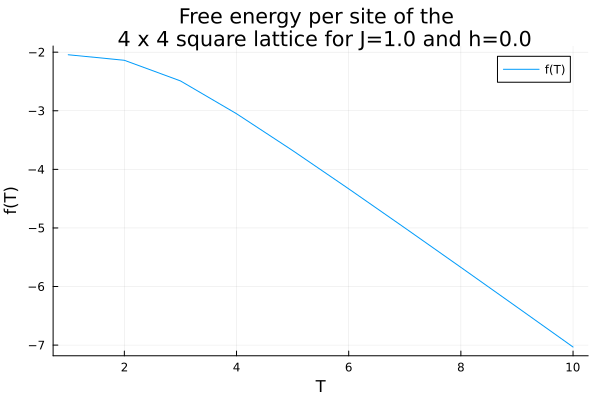

In [54]:
function free_energy_per_site_square(L_h, L_v, T, J, h)
#=
    Compute the free energy per site of a L_h×L_v Ising model with periodic boundary conditions.

    # Arguments
    - `L_h` : Length of the horizontal dimension of the lattice. 
    - `L_v` : Length of the vertical dimension of the lattice.
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The free energy per site of the L_h×L_v square lattice Ising model.
=#
    Z = Z_square(L_h, L_v, T, J, h)
    return -kb*T*log(Z)/(L_h*L_v)
end

## Plot of the free energy per site as a function of the temperature

# Value of the model's parameters
J= 1.0
h= 0.0
L_h, L_v = 4, 4 

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

y_f = free_energy_per_site_square.(L_h, L_v, T_range, J, h)
plot(T_range, y_f, 
    label="f(T)", 
    title="Free energy per site of the \n $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="f(T)", 
    legend=:topright)
#savefig("free_energy_per_site_2x2.png")

### Magnetization

#### m(T)

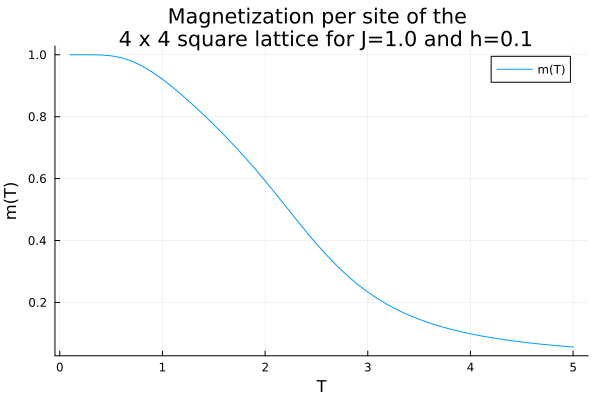

In [57]:
function magnetization_per_site_square(L_h, L_v, T, J, h)
#=
    Compute the mean magnetization per site of the L_h×L_v square lattice Ising model with periodic boundary conditions.

    # Arguments
    - `L_h` : Length of the horizontal dimension of the lattice. 
    - `L_v` : Length of the vertical dimension of the lattice.
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.

    # Returns
    - The mean magnetization of the L_h×L_v square lattice Ising model.
=#
    f(x) = free_energy_per_site_square(L_h, L_v, T, J, x)
    m = -numerical_derivative(f, h)
    return m
end

## Plot of the partition function as a function of the temperature

# Value of the model's parameters
J= 1.0
h= 0.1
L_h, L_v = 4, 4

# Temperature range
T_min = 0.1
T_max = 5
T_step = 0.1

T_range = T_min:T_step:T_max

y_m = magnetization_per_site_square.(L_h, L_v, T_range, J, h)
plot(T_range, y_m, 
    label="m(T)", 
    title="Magnetization per site of the \n $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="m(T)", 
    legend=:topright)
#savefig("magnetization_per_site_2x2.png")


## Onsager's Solution

In [58]:
function ising_free_energy_per_site(T, J)
#=
    Compute the exact free energy per site of the 2D classical Ising model at zero field
    using Onsager’s analytic solution.
    
    Parameters:
    - `T`: Temperature.
    - `J`: Coupling constant.

    Returns:
    - `f`: The free energy per site.
=#
    beta = 1/(kb*T) # Inverse temperature
    
    K = beta * J
    # Compute kappa, which appears in the analytic expression
    k = 1 / (sinh(2*K)^2)
    
    # Define the integrand for the integral term in Onsager's solution.
    integrand(θ) = log(cosh(2*K)^2 + sqrt(1 + k^2 - 2*k*cos(2*θ))/k)
    
    # Perform the integration from 0 to π.
    I, err = quadgk(integrand, 0, π)
    
    # Onsager’s result gives:
    #   -β f = ln(2cosh(2βJ)) + (1/(2π)) * I
    f = -(log(2)/2 + (1/(2π)) * I)/beta

    return f
end


ising_free_energy_per_site (generic function with 1 method)

#### Exact f(T) in the thermodynamic limit

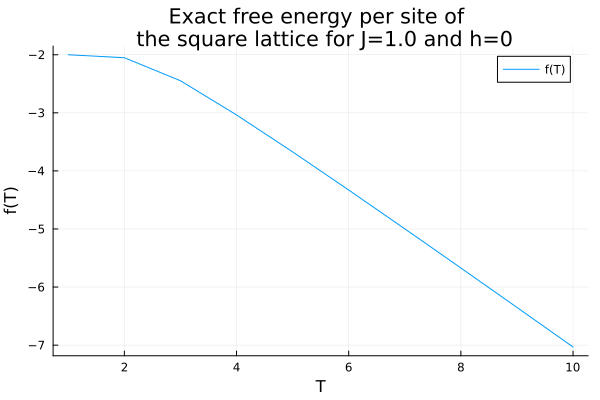

In [61]:
## Plot of the free energy per site as a function of the temperature

# Value of the model's parameters
J= 1.0

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

y_f = ising_free_energy_per_site.(T_range, J)
plot(T_range, y_f, 
    label="f(T)", 
    title="Exact free energy per site of \n the square lattice for J=$J and h=0", 
    xlabel="T", 
    ylabel="f(T)", 
    legend=:topright)
#savefig("free_energy_per_site_2x2.png")

#### Exact m(T) in the thermodynamic limit

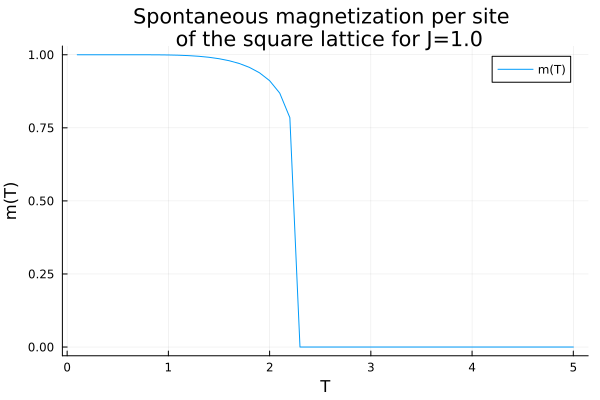

In [66]:
function mag_exact(T, J)
#=
    Compute the exact mean spontaneous magnetization per site of the 2D classical Ising model at zero field
    using Yang’s analytic solution.
    
    Parameters:
    - `T`: Temperature.
    - `J`: Coupling constant.

    Returns:
    - `m`: The exact mean spontaneous magnetization per site.
=#
    T_c = (2/log(1+sqrt(2)))*J/kb
    if T < T_c
        return (1.0 - sinh(2*J/(kb*T))^(-4))^(1/8)
    else
        return 0
    end
end

## Plot of the mean spontaneous magnetization per site as a function of the temperature

# Value of the model's parameters
J= 1.0

# Temperature range
T_min = 0.1
T_max = 5
T_step = 0.1

T_range = T_min:T_step:T_max

y_m = mag_exact.(T_range, J)
plot(T_range, y_m, 
    label="m(T)", 
    title="Spontaneous magnetization per site \n of the square lattice for J=$J", 
    xlabel="T", 
    ylabel="m(T)", 
    legend=:topright)
#savefig("spontaneous_magnetization_per_site.png")


#### $m(\frac{\alpha_c - \alpha}{\alpha_c})$

To look at what happens near the critical point, we change the x scale of the plots. 

We define $\alpha$ as : 

$\alpha = e^{\frac{-2 J}{k_B T}}$

and $\alpha_c = e^{\frac{-2 J}{k_B T_c}}$ where $T_c$ is the critical temperature of the system. 

Then, we plot the physical quantities as a function of $\frac{\alpha_c - \alpha}{\alpha_c}$

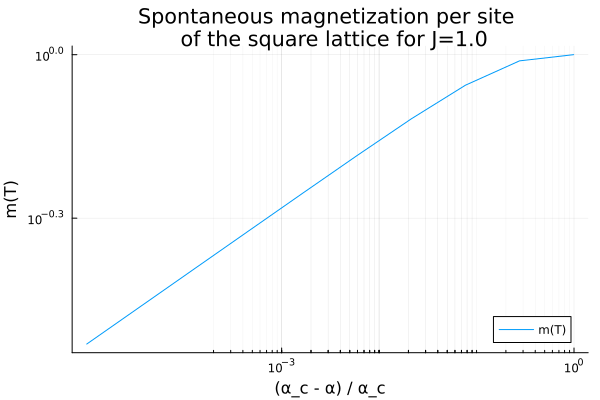

In [72]:
## Plot of the mean spontaneous magnetization per site as a function of (α_c - α)/α_c

# Value of the model's parameter
J= 1.0

# ratio range
ratio_min = 1e-5
ratio_max = 0.99
nb_steps = 10

ratio_range = maprange(log, ratio_min, ratio_max, length=nb_steps)

# Critical temperature
T_c = (2/log(1+sqrt(2)))*J/kb

# Critical alpha value corresponding to T_c.
alpha_c = f_alpha(T_c)

# f_alpha: given temperature t, compute alpha(t)
f_alpha(t) = exp(-2 * J / (kb * t))

# finv_alpha: given alpha, recover the corresponding temperature-like parameter
finv_alpha(a) = -2 * J / (kb * log(a))

# ratio function: normalized difference between alpha_c and a given alpha.
ratio(a) = (alpha_c - a) / alpha_c

# Inverse ratio: recovers an "alpha" value from a normalized value.
inv_ratio(r) = alpha_c * (1 - r)

y_m = mag_exact.(finv_alpha.(inv_ratio.(ratio_range)), J)
plot(ratio_range, y_m, 
    label="m(T)", 
    title="Spontaneous magnetization per site \n of the square lattice for J=$J", 
    xlabel="(α_c - α) / α_c", 
    ylabel="m(T)", 
    legend=:bottomright)
plot!(xscale=:log10, yscale=:log10, minorgrid=true)

# TRG Square Lattice

Here we implement the TRG algorithm on the square lattice Ising model.

## Cross Tensor in the middle of the squares

We translate the partition function of the model into a tensor network as described in the document attached to this jupyter notebook.

### TRG on a $L_h \times L_v$ square lattice

It may be useful to consult Appendix C of the document attached to this jupyter notebook for a better understanding of the TRG implementation used here.

In [73]:
debug = false # plot informations in order to debug the code

# Value of the model's parameters
T = 1
J= 1.0
h= 1
L_h, L_v = 4, 4 

maxd = 32 # maximum bond dimension

beta = 1.0/(kb*T)

topscale = log2((L_h)*(L_v)) - 1

println("topscale = ", topscale)
println(" ")

### Indices on the initial "A" tensor
#=
l---------u
| \     / |
|  \   /  |
|    A    |
|  /   \  |
| /     \ |
d---------r
=#

dim0 = 2

l = Index(dim0, "scale=0,left")
u = Index(dim0, "scale=0,up")
r = Index(dim0, "scale=0,rigth")
d = Index(dim0, "scale=0,down")
A = ITensor(l, u, r, d)

if debug
    println("inds(A) = ", inds(A))
end

### Values on the initial "A" tensor

Sig(s::Int64) = 1 - 2*(s-1)

for vl in 1:dim0, vu in 1:dim0, vr in 1:dim0, vd in 1:dim0
    sl, su, sr, sd = Sig(vl), Sig(vu), Sig(vr), Sig(vd)
    P = exp(beta*(J*(sl*su + su*sr + sr*sd + sd*sl) + (h/2)*(sl+su+sr+sd)))
    A[l=>vl, u=>vu, r=>vr, d=>vd] = P
end

if debug
    println("A = ", A)
end

### Partition function calculation

z = 1.0 # partition function per site
trA = 0.0

# Loop over the scales
for scale in 1:(topscale)
    println("scale = ", scale)

    if debug 
        println(" ")
        println("A = ", A)
        println(" ")
        println("inds(A) = ", inds(A))
        println(" ")
    end

    # Horizontal SVD decomposition 
    U,S,V = svd(A,l,u, maxdim=maxd)

    if debug
        println("S = ", S)
        println("inds(S) = ", inds(S))
        println("inds(U) = ", inds(U))
        println("inds(V) = ", inds(V))
        println(" ")
    end 

    if debug
        println("sqrt.(S) = ", sqrt.(S))
        println("inds(sqrt.(S)) = ", inds(sqrt.(S)))
        println(" ")
    end 

    Fr = U*sqrt.(S)
    Fl = sqrt.(S)*V

    if debug 
        println("inds(Fr) = ", inds(Fr))    
        println("inds(Fl) = ", inds(Fl))
        println(" ")
    end

    # Index renaming
    r_new = commonind(Fr, S)

    if debug 
        println("r_new = ", r_new)    
        println(" ")
    end

    r_new = replacetags(r_new, r_new.tags, "right,scale=$scale")

    l_new = commonind(Fl, S)

    if debug   
        println("l_new = ", l_new)
        println(" ")
    end

    l_new = replacetags(l_new, l_new.tags, "left,scale=$scale")

    if debug 
        println("r_new = ", r_new)    
        println("l_new = ", l_new)
        println(" ")
    end

    replaceind!(Fr, commonind(Fr, S), r_new)
    replaceind!(Fl, commonind(Fl, S), l_new)

    # Vertical SVD decomposition
    U,S,V = svd(A,l,d, maxdim=maxd)

    if debug
        println("S = ", S)
        println("inds(S) = ", inds(S))
        println("inds(U) = ", inds(U))
        println("inds(V) = ", inds(V))
        println(" ")
    end
    
    Fu = U*sqrt.(S)
    Fd = sqrt.(S)*V

    if debug
        println("inds(Fu) = ", inds(Fu))
        println("inds(Fd) = ", inds(Fd))
        println(" ")
    end

    # Index renaming
    u_new = commonind(Fu, S)

    if debug 
        println("u_new = ", u_new)    
        println(" ")
    end

    u_new = replacetags(u_new, u_new.tags, "up,scale=$scale")

    if debug 
        println("u_new = ", u_new)    
        println(" ")
    end

    d_new = commonind(Fd, S)

    if debug 
        println("d_new = ", d_new)    
        println(" ")
    end

    d_new = replacetags(d_new, d_new.tags, "down,scale=$scale")

    if debug 
        println("d_new = ", d_new)    
        println(" ")
    end
    
    replaceind!(Fu, commonind(Fu, S), u_new)
    replaceind!(Fd, commonind(Fd, S), d_new)

    if debug 
        println("inds(Fl) = ", inds(Fl))
        println("inds(Fr) = ", inds(Fr))
        println("inds(Fu) = ", inds(Fu))
        println("inds(Fd) = ", inds(Fd))
        println(" ")
    end

    replaceind!(Fl, r, l)
    replaceind!(Fu, d, u)
    replaceind!(Fr, l, r)
    replaceind!(Fd, u, d)

    if debug 
        println("inds(Fl) = ", inds(Fl))
        println("inds(Fr) = ", inds(Fr))
        println("inds(Fu) = ", inds(Fu))
        println("inds(Fd) = ", inds(Fd))
        println(" ")
    end

    # Contraction
    A = Fl * Fu * Fr * Fd

    if debug
        println("inds(A) = ", inds(A))
        println("l_new = ", l_new)
        println("r_new = ", r_new)
        println("u_new = ", u_new)
        println("d_new = ", d_new)
    end

    # Index renaming

    l = l_new
    r = r_new
    u = u_new
    d = d_new

    # Tracing A
    trA = A * delta(l_new, r_new) * delta(u_new, d_new)
    A = A./trA[] # normalize A
    z = z * trA[]^(1. / 2^(1 + scale)) # update z
    println("z = ", z)
end

println(" ")
println("L_h = ", L_h, ", L_v = ", L_v)

if L_h <= 4 && L_v <= 4
    Z = z^(L_h*L_v) 
    Z_exact = Z_square(L_h, L_v, T, J, h)
    println("The partition function Z = ", Z)
    println("Z_square($L_h, $L_v, $T, $J, $h) : ", Z_exact)
    println("Z ≈ Z_square($L_h, $L_v, $T, $J, $h) : ", Z ≈ Z_exact)
else
    Z = z^(L_h*L_v) 
    println("The partition function Z = ", Z)
    println("ln(Z) : ", (L_h*L_v)*log(z))
    println("ln(2^(L_h*L_v)) : ", (L_h*L_v)*log(2))
end

topscale = 3.0
 
scale = 1.0
z = 20.088272865044267
scale = 2.0
z = 20.086453568865483
scale = 3.0
z = 20.086453276574748
 
L_h = 4, L_v = 4
The partition function Z = 7.02185960705858e20
Z_square(4, 4, 1, 1.0, 1) : 7.021859607058587e20
Z ≈ Z_square(4, 4, 1, 1.0, 1) : true


### TRG in the thermodynamic limit

In the TRG algorithm, tensors are divided by their trace at each iteration, to avoid having numerical values that are too large after a few iterations. There are then several ways of recovering the partition function after performing these “renormalizations” of the tensors. Two are proposed in the following two functions, which are totally equivalent.

#### First option

In [75]:

function TRG_cross(T, J, h, maxd , prec=1e-5, max_step=1000, debug = false)
#=
    This function iterates the TRG algorithm and calculates the "partition function per site" at each iteration. 
    The function stops when the difference in the "partition function per site" between 2 iterations is less than prec.

    # Arguments
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.
    - `prec` : The prec which will tell the function when to stop.
    - `max_step` : The maximal number of iteration that the function will do.
    - `debug` : Plot informations in order to debug the code

    # Returns
    - The "partition function per site" of the square lattice Ising model in the thermodynamic limit computed by the TRG algorithm
    - The free energy per site of the square lattice Ising model in the thermodynamic limit computed by the TRG algorithm
=#
    beta = 1.0/(kb*T)

    T_c = (2/log(1+sqrt(2)))*J/kb
    alpha = exp(-2*beta*J)
    alpha_c = exp(-2*J/(kb*T_c))

    println("T_c = ", T_c)
    println("(alpha_c-alpha)/alpha_c = ", (alpha_c-alpha)/alpha_c)
    println(" ")

    println("precision = ", prec)
    println(" ")

    ### Indices on the initial "A" tensor
    #=
    l---------u
    | \     / |
    |  \   /  |
    |    A    |
    |  /   \  |
    | /     \ |
    d---------r
    =#

    dim0 = 2

    l = Index(dim0, "scale=0,left")
    u = Index(dim0, "scale=0,up")
    r = Index(dim0, "scale=0,rigth")
    d = Index(dim0, "scale=0,down")
    A = ITensor(l, u, r, d)

    if debug
        println("inds(A) = ", inds(A))
    end

    ### Values on the initial "A" tensor

    Sig(s::Int64) = 1 - 2*(s-1)

    for vl in 1:dim0, vu in 1:dim0, vr in 1:dim0, vd in 1:dim0
        sl, su, sr, sd = Sig(vl), Sig(vu), Sig(vr), Sig(vd)
        P = exp(beta*(J*(sl*su + su*sr + sr*sd + sd*sl) + (h/2)*(sl+su+sr+sd)))
        A[l=>vl, u=>vu, r=>vr, d=>vd] = P
    end

    if debug
        println("A = ", A)
    end

    ### Partition function calculation

    old_z = 1.0 # partition function per site
    new_z = 1.0 # partition function per site
    trA = 0.0

    # Loop over the scales
    stop = false
    scale = 0
    nb_step = 0
    while !stop && nb_step < max_step
        scale += 1
        nb_step += 1
        println("scale = ", scale)

        if debug 
            println(" ")
            println("A = ", A)
            println(" ")
            println("inds(A) = ", inds(A))
            println(" ")
        end

        # Horizontal SVD decomposition 
        U,S,V = svd(A,l,u, maxdim=maxd)

        if debug
            println("S = ", S)
            println("inds(S) = ", inds(S))
            println("inds(U) = ", inds(U))
            println("inds(V) = ", inds(V))
            println(" ")
        end 

        if debug
            println("sqrt.(S) = ", sqrt.(S))
            println("inds(sqrt.(S)) = ", inds(sqrt.(S)))
            println(" ")
        end 

        Fr = U*sqrt.(S)
        Fl = sqrt.(S)*V

        if debug 
            println("inds(Fr) = ", inds(Fr))    
            println("inds(Fl) = ", inds(Fl))
            println(" ")
        end

        # Index renaming
        r_new = commonind(Fr, S)

        if debug 
            println("r_new = ", r_new)    
            println(" ")
        end

        r_new = replacetags(r_new, r_new.tags, "right,scale=$scale")

        l_new = commonind(Fl, S)

        if debug   
            println("l_new = ", l_new)
            println(" ")
        end

        l_new = replacetags(l_new, l_new.tags, "left,scale=$scale")

        if debug 
            println("r_new = ", r_new)    
            println("l_new = ", l_new)
            println(" ")
        end

        replaceind!(Fr, commonind(Fr, S), r_new)
        replaceind!(Fl, commonind(Fl, S), l_new)

        # Vertical SVD decomposition
        U,S,V = svd(A,l,d, maxdim=maxd)

        if debug
            println("S = ", S)
            println("inds(S) = ", inds(S))
            println("inds(U) = ", inds(U))
            println("inds(V) = ", inds(V))
            println(" ")
        end
        
        Fu = U*sqrt.(S)
        Fd = sqrt.(S)*V

        if debug
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        # Index renaming
        u_new = commonind(Fu, S)

        if debug 
            println("u_new = ", u_new)    
            println(" ")
        end

        u_new = replacetags(u_new, u_new.tags, "up,scale=$scale")

        if debug 
            println("u_new = ", u_new)    
            println(" ")
        end

        d_new = commonind(Fd, S)

        if debug 
            println("d_new = ", d_new)    
            println(" ")
        end

        d_new = replacetags(d_new, d_new.tags, "down,scale=$scale")

        if debug 
            println("d_new = ", d_new)    
            println(" ")
        end
        
        replaceind!(Fu, commonind(Fu, S), u_new)
        replaceind!(Fd, commonind(Fd, S), d_new)

        if debug 
            println("inds(Fl) = ", inds(Fl))
            println("inds(Fr) = ", inds(Fr))
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        replaceind!(Fl, r, l)
        replaceind!(Fu, d, u)
        replaceind!(Fr, l, r)
        replaceind!(Fd, u, d)

        if debug 
            println("inds(Fl) = ", inds(Fl))
            println("inds(Fr) = ", inds(Fr))
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        # Contraction
        A = Fl * Fu * Fr * Fd

        if debug
            println("inds(A) = ", inds(A))
            println("l_new = ", l_new)
            println("r_new = ", r_new)
            println("u_new = ", u_new)
            println("d_new = ", d_new)
        end

        # Index renaming

        l = l_new
        r = r_new
        u = u_new
        d = d_new

        # Tracing A
        trA = A * delta(l_new, r_new) * delta(u_new, d_new)
        A = A./trA[] # normalize A
        new_z = old_z * trA[]^(1. / 2^(1 + scale)) # update z
        println("z = ", new_z)
        if abs(new_z - old_z) < prec
            stop = true
        end
        old_z = new_z
    end
    
    println(" ")
    println("final scale = ", scale)

    N = 2^(scale+1) # number of sites in the lattice
    println("N = ", N)
    Z = new_z^N # partition function
    F = -log(Z)/beta # free energy
    f = -log(new_z)/beta # free energy per site

    println(" ")
    println("The partition function Z = ", Z)
    println("The free energy F = ", F)
    println(" ")
    println("The partition function per site z = ", new_z)
    println("The free energy per site f = ", f)

    return new_z, f
end


TRG_cross (generic function with 4 methods)

#### Second Option

In [76]:

function Z_from_factors(factors)
#= 
    Given a list of "normalization facors" used during the TRG algorithm, 
    this function recover the partition function computed by the TRG algorithm.
=# 
    Z = 1.0
    N = size(factors)[1] # number of TRG steps
    k = N-1
    for factor in factors
        Z *= factor[1]^(2^k)
        k -= 1 
    end
    return Z
end

function z_from_factors(factors)
#= 
    Given a list of "normalization facors" used during the TRG algorithm, 
    this function recover the "mean partition function per site" computed by the TRG algorithm.
=# 
    z = 1.0
    k = -2.0
    for factor in factors
        z *= factor[1]^(2^k)
        k -= 1 
    end
    return z
end

function TRG_cross_bis(T, J, h, maxd , prec=1e-5, max_step=10000, debug = false)
#=
    This function iterates the TRG algorithm and calculates the "partition function per site" at each iteration. 
    The function stops when the difference in the "partition function per site" between 2 iterations is less than prec.

    # Arguments
    - `T` : Temperature.
    - `J` : Coupling constant between nearest neighbors.
    - `h` : External magnetic field strength.
    - `prec` : The prec which will tell the function when to stop.
    - `max_step` : The maximal number of iteration that the function will do.
    - `debug` : Plot informations in order to debug the code

    # Returns
    - The "partition function per site" of the square lattice Ising model in the thermodynamic limit computed by the TRG algorithm
    - The free energy per site of the square lattice Ising model in the thermodynamic limit computed by the TRG algorithm
=#
    beta = 1.0/(kb*T)

    T_c = (2/log(1+sqrt(2)))*J/kb
    alpha = exp(-2*beta*J)
    alpha_c = exp(-2*J/(kb*T_c))

    println("T_c = ", T_c)
    println("(alpha_c-alpha)/alpha_c = ", (alpha_c-alpha)/alpha_c)
    println(" ")

    println("precision = ", prec)
    println(" ")

    ### Indices on the initial "A" tensor
    #=
    l---------u
    | \     / |
    |  \   /  |
    |    A    |
    |  /   \  |
    | /     \ |
    d---------r
    =#

    dim0 = 2

    l = Index(dim0, "scale=0,left")
    u = Index(dim0, "scale=0,up")
    r = Index(dim0, "scale=0,rigth")
    d = Index(dim0, "scale=0,down")
    A = ITensor(l, u, r, d)

    if debug
        println("inds(A) = ", inds(A))
    end

    ### Values on the initial "A" tensor

    Sig(s::Int64) = 1 - 2*(s-1)

    for vl in 1:dim0, vu in 1:dim0, vr in 1:dim0, vd in 1:dim0
        sl, su, sr, sd = Sig(vl), Sig(vu), Sig(vr), Sig(vd)
        P = exp(beta*(J*(sl*su + su*sr + sr*sd + sd*sl) + (h/2)*(sl+su+sr+sd)))
        A[l=>vl, u=>vu, r=>vr, d=>vd] = P
    end

    if debug
        println("A = ", A)
    end

    ### Partition function calculation

    old_z = 1.0 # partition function per site
    new_z = 1.0 # partition function per site
    trA = 0.0

    # Loop over the scales
    stop = false
    scale = 0
    nb_step = 0
    factors = [] 
    while !stop && nb_step < max_step
        scale += 1
        nb_step += 1
        println("scale = ", scale)

        if debug 
            println(" ")
            println("A = ", A)
            println(" ")
            println("inds(A) = ", inds(A))
            println(" ")
        end

        # Horizontal SVD decomposition 
        U,S,V = svd(A,l,u, maxdim=maxd)

        if debug
            println("S = ", S)
            println("inds(S) = ", inds(S))
            println("inds(U) = ", inds(U))
            println("inds(V) = ", inds(V))
            println(" ")
        end 

        if debug
            println("sqrt.(S) = ", sqrt.(S))
            println("inds(sqrt.(S)) = ", inds(sqrt.(S)))
            println(" ")
        end 

        Fr = U*sqrt.(S)
        Fl = sqrt.(S)*V

        if debug 
            println("inds(Fr) = ", inds(Fr))    
            println("inds(Fl) = ", inds(Fl))
            println(" ")
        end

        # Index renaming
        r_new = commonind(Fr, S)

        if debug 
            println("r_new = ", r_new)    
            println(" ")
        end

        r_new = replacetags(r_new, r_new.tags, "right,scale=$scale")

        l_new = commonind(Fl, S)

        if debug   
            println("l_new = ", l_new)
            println(" ")
        end

        l_new = replacetags(l_new, l_new.tags, "left,scale=$scale")

        if debug 
            println("r_new = ", r_new)    
            println("l_new = ", l_new)
            println(" ")
        end

        replaceind!(Fr, commonind(Fr, S), r_new)
        replaceind!(Fl, commonind(Fl, S), l_new)

        # Vertical SVD decomposition
        U,S,V = svd(A,l,d, maxdim=maxd)

        if debug
            println("S = ", S)
            println("inds(S) = ", inds(S))
            println("inds(U) = ", inds(U))
            println("inds(V) = ", inds(V))
            println(" ")
        end
        
        Fu = U*sqrt.(S)
        Fd = sqrt.(S)*V

        if debug
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        # Index renaming
        u_new = commonind(Fu, S)

        if debug 
            println("u_new = ", u_new)    
            println(" ")
        end

        u_new = replacetags(u_new, u_new.tags, "up,scale=$scale")

        if debug 
            println("u_new = ", u_new)    
            println(" ")
        end

        d_new = commonind(Fd, S)

        if debug 
            println("d_new = ", d_new)    
            println(" ")
        end

        d_new = replacetags(d_new, d_new.tags, "down,scale=$scale")

        if debug 
            println("d_new = ", d_new)    
            println(" ")
        end
        
        replaceind!(Fu, commonind(Fu, S), u_new)
        replaceind!(Fd, commonind(Fd, S), d_new)

        if debug 
            println("inds(Fl) = ", inds(Fl))
            println("inds(Fr) = ", inds(Fr))
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        replaceind!(Fl, r, l)
        replaceind!(Fu, d, u)
        replaceind!(Fr, l, r)
        replaceind!(Fd, u, d)

        if debug 
            println("inds(Fl) = ", inds(Fl))
            println("inds(Fr) = ", inds(Fr))
            println("inds(Fu) = ", inds(Fu))
            println("inds(Fd) = ", inds(Fd))
            println(" ")
        end

        # Contraction
        A = Fl * Fu * Fr * Fd

        if debug
            println("inds(A) = ", inds(A))
            println("l_new = ", l_new)
            println("r_new = ", r_new)
            println("u_new = ", u_new)
            println("d_new = ", d_new)
        end

        # Index renaming

        l = l_new
        r = r_new
        u = u_new
        d = d_new

        # Tracing A
        trA = A * delta(l_new, r_new) * delta(u_new, d_new)
        A = A./trA[] # normalize A
        push!(factors, [trA[], scale]) # store the factor
        new_z = z_from_factors(factors) # partition function per site
        println("z = ", new_z)
        if abs(new_z - old_z) < prec
            stop = true
        end
        old_z = new_z
    end
    
    println(" ")
    println("final scale = ", scale)

    N = 2^(scale+1) # number of sites in the lattice
    println("N = ", N)
    z = z_from_factors(factors) # partition fun1ction per site
    Z = Z_from_factors(factors) # partition function
    F = -log(Z)/beta # free energy
    f = -log(z)/beta # free energy per site

    println(" ")
    println("The partition function Z = ", Z)
    println("The free energy F = ", F)
    println(" ")
    println("The partition function per site z = ", z)
    println("The free energy per site f = ", f)

    return z, f
end


TRG_cross_bis (generic function with 4 methods)

#### Checking that the two methods are equivalent.

In [78]:
L_h, L_v = 4, 4
topscale = log2((L_h)*(L_v)) - 1
T = 1
J = 1.0
h = 0.0
maxd = 32
prec = 1e-3

z_bis, f_bis = TRG_cross_bis(T, J, h, maxd , prec, topscale)
println(" ")
println("Ref:")
z, f = TRG_cross(T, J, h, maxd , prec, topscale)
println(" ")
println("True:")
Z_true = Z_square(L_h, L_v, T, J, h)
println("Z_square($L_h, $L_v, $T, $J, $h) = ", Z_true)
z_true = Z_true^(1/(L_h*L_v))
println("z_true = ", z_true)
println((" "))
println("z_bis == z : ", z_bis == z)
println("z_bis ≈ z_true : ", z_bis ≈ z_true)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 0.001
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
 
final scale = 3
N = 16
 
The partition function Z = 1.5880869249537166e14
The free energy F = -32.69872140187932
 
The partition function per site z = 7.718886266388247
The free energy per site f = -2.043670087617458
 
Ref:
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 0.001
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
 
final scale = 3
N = 16
 
The partition function Z = 1.5880869249537188e14
The free energy F = -32.698721401879325
 
The partition function per site z = 7.718886266388247
The free energy per site f = -2.043670087617458
 
True:
Z_square(4, 4, 1, 1.0, 0.0) = 1.588086924952485e14
z_true = 7.718886266387872
 
z_bis == z : true
z_bis ≈ z_true : true


### f(h)

In [81]:
## Plot of the free energy per site computed by the TRG algorithm as a function of the external field h

# Value of the model's parameters
J = 1.0
maxd = 8
prec = 1e-5
T_c = (2/log(1+sqrt(2)))*J/kb
T = 0.99*T_c

# External field h range
h_min = 0.0
h_max = 0.001
h_step = 0.0001

# D_max range
D_min = 10
D_max = 16
D_step = 2

h_range = h_min:h_step:h_max

f_h(h) = TRG_cross(T, J, h, maxd, prec)[2]
y = f_h.(h_range)
plot(h_range, y, 
    label="f(T) for maxd=$maxd", 
    title="Free energy per site \n of the square lattice for J=$J and T=$T", 
    xlabel="h", 
    ylabel="f(T)", 
    legend=:topright)

for maxd in D_min:D_step:D_max
    f_h(h) = TRG_cross(T, J, h, maxd, prec)[2]
    y = f_h.(h_range)
    plot!(h_range, y, label="maxd=$maxd")
end
savefig("f(h).png")

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.008863251249263281
 
precision = 1.0e-5
 
scale = 1
z = 3.013437146374373
scale = 2
z = 2.7626639399152633
scale = 3
z = 2.656547448390363
scale = 4
z = 2.6024499131166943
scale = 5
z = 2.576368054777586
scale = 6
z = 2.5632570225545925
scale = 7
z = 2.556693644310163
scale = 8
z = 2.5533794995526207
scale = 9
z = 2.5517023377526438
scale = 10
z = 2.550852669883788
scale = 11
z = 2.5504235082191733
scale = 12
z = 2.550207908840717
scale = 13
z = 2.550100018408609
scale = 14
z = 2.5500460757789143
scale = 15
z = 2.5500191051335235
scale = 16
z = 2.550005619920205
scale = 17
z = 2.5499988773402906
 
final scale = 17
N = 262144
 
The partition function Z = Inf
The free energy F = -Inf
 
The partition function per site z = 2.5499988773402906
The free energy per site f = -2.102926621289513
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.008863251249263281
 
precision = 1.0e-5
 
scale = 1
z = 3.0134371568600598
scale = 2
z = 2.762663958

"c:\\Users\\matth\\Desktop\\Tout\\Dossier\\neel tensor network\\Julia\\f(h).png"

### m(h)

In [82]:
## Plot of the mean magnetization per site computed by the TRG algorithm as a function of the external field h

# Value of the model's parameters
J = 1.0
maxd = 8
prec = 1e-5
T_c = (2/log(1+sqrt(2)))*J/kb
T = 1

# External field h range
h_min = 0.01
h_max = 10.01
h_step = 0.1

# D_max range
D_min = 10
D_max = 16
D_step = 2

h_range = h_min:h_step:h_max

function magnetization_per_site_TRG(T, J, h, maxd)
    f_TRG(x) = TRG_cross(T, J, x, maxd, prec)[2]
    m = -numerical_derivative(f_TRG, h)
    return m
end

y_m_TRG = magnetization_per_site_TRG.(T, J, h_range, maxd)
plot(h_range, y_m_TRG, 
    label="f(T) for maxd=$maxd", 
    title="magnetization per site of the square lattice for J=$J and T=$T", 
    xlabel="h", 
    ylabel="f(T)", 
    legend=:bottomright)

for maxd in D_min:D_step:D_max
    y_m_TRG = magnetization_per_site_TRG.(T, J, h_range, maxd)
    plot!(h_range, y_m_TRG, label="maxd=$maxd")
end
savefig("m(h).png")

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 1.0e-5
 
scale = 1
z = 8.793660187239427
scale = 2
z = 8.064522765098715
scale = 3
z = 7.726313169648365
scale = 4
z = 7.56781077586818
scale = 5
z = 7.498949309450471
scale = 6
z = 7.476728978273082
scale = 7
z = 7.473432759082602
scale = 8
z = 7.473328157180861
scale = 9
z = 7.473327968430089
 
final scale = 9
N = 1024
 
The partition function Z = Inf
The free energy F = -Inf
 
The partition function per site z = 7.473327968430089
The free energy per site f = -2.0113404111027773
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 1.0e-5
 
scale = 1
z = 8.792958277290406
scale = 2
z = 8.063236925322204
scale = 3
z = 7.723865504835607
scale = 4
z = 7.5631354085663345
scale = 5
z = 7.490500252530825
scale = 6
z = 7.463963845541342
scale = 7
z = 7.458696870371243
scale = 8
z = 7.458408279420944
scale = 9
z = 7.45840682136663
 
final scale = 9
N = 1024
 
The partition function

Excessive output truncated after 524337 bytes.

z = 122.85455962454593
 
final scale = 2
N = 8
 
The partition function Z = 5.189556399516659e16
The free energy F = -38.48800970927479
 
The partition function per site z = 122.85455962454593
The free energy per site f = -4.811001213659349
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 1.0e-5
 
scale = 1
z = 122.60909717733232
scale = 2
z = 122.6090966471842
 
final scale = 2
N = 8
 
The partition function Z = 5.1071844305033896e16
The free energy F = -38.47200974819473
 
The partition function per site z = 122.6090966471842
The free energy per site f = -4.809001218524341
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 1.0e-5
 
scale = 1
z = 122.74404105885223
scale = 2
z = 122.74404053047837
 
final scale = 2
N = 8
 
The partition function Z = 5.152325874628777e16
The free energy F = -38.48080972676949
 
The partition function per site z = 122.74404053047837
The free energy per site f = -4.810101215846187
T_c = 2.

"c:\\Users\\matth\\Desktop\\Tout\\Dossier\\neel tensor network\\Julia\\m(h).png"

## Comparison with exact solution

Here we compare the results of the TRG algorithm with the exact solutions. 

#### Partition function vs Temperature ($L_h \times L_v$ lattice)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 0.001
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
 
final scale = 3
N = 16
 
The partition function Z = 1.5880869249537166e14
The free energy F = -32.69872140187932
 
The partition function per site z = 7.718886266388247
The free energy per site f = -2.043670087617458
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.11186046380566884
 
precision = 0.001
 
scale = 1
z = 3.3182198085348973
scale = 2
z = 3.0367672721867858
scale = 3
z = 2.9127144437034076
 
final scale = 3
N = 16
 
The partition function Z = 2.683901361226269e7
The free energy F = -34.21073423746316
 
The partition function per site z = 2.9127144437034076
The free energy per site f = -2.1381708898414478
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = -0.23949857192300522
 
precision = 0.001
 
scale = 1
z = 2.5292475202957845
scale = 2
z = 2.350426284522183
scale = 3
z = 2.2934668727

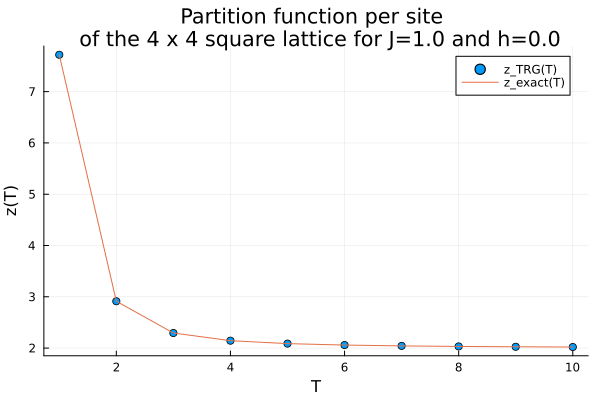

In [ ]:
## Plot of the "partition function per site" as a function of the temperature

# Value of the model's parameters
L_h, L_v = 4, 4
topscale = log2((L_h)*(L_v)) - 1
J = 1.0
h = 0.0
maxd = 32
prec = 1e-3

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

z_TRG(t) = TRG_cross_bis(t, J, h, maxd, prec, topscale)[1]
y_z_TRG = z_TRG.(T_range)
scatter(T_range, y_z_TRG, 
    label="z_TRG(T)", 
    title="Partition function per site \n of the $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="z(T)", 
    legend=:topright)

y_z_exact = Z_square.(L_h, L_v, T_range, J, h).^(1/(L_h*L_v))
plot!(T_range, y_z_exact, 
    label="z_exact(T)")

#savefig("partition_function_per_site.png")

#### Free energy per site vs Temperature ($L_h \times L_v$ lattice)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 0.001
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
 
final scale = 3
N = 16
 
The partition function Z = 1.5880869249537166e14
The free energy F = -32.69872140187932
 
The partition function per site z = 7.718886266388247
The free energy per site f = -2.043670087617458
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.11186046380566884
 
precision = 0.001
 
scale = 1
z = 3.3182198085348973
scale = 2
z = 3.0367672721867858
scale = 3
z = 2.9127144437034076
 
final scale = 3
N = 16
 
The partition function Z = 2.683901361226269e7
The free energy F = -34.21073423746316
 
The partition function per site z = 2.9127144437034076
The free energy per site f = -2.1381708898414478
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = -0.23949857192300522
 
precision = 0.001
 
scale = 1
z = 2.5292475202957845
scale = 2
z = 2.350426284522183
scale = 3
z = 2.2934668727

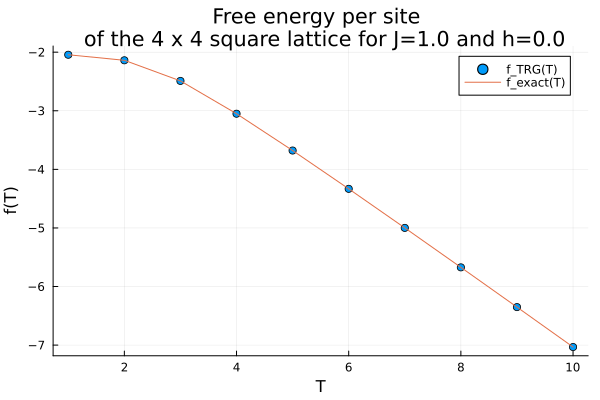

In [ ]:
## Plot of the free energy per site as a function of the temperature

# Value of the model's parameters
L_h, L_v = 4, 4
topscale = log2((L_h)*(L_v)) - 1
J = 1.0
h = 0.0
maxd = 32
prec = 1e-3

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

f_TRG(t) = TRG_cross_bis(t, J, h, maxd, prec, topscale)[2]
y_f_TRG = f_TRG.(T_range)
scatter(T_range, y_f_TRG, 
    label="f_TRG(T)", 
    title="Free energy per site \n of the $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="f(T)", 
    legend=:topright)

y_f_exact = free_energy_per_site_square.(L_h, L_v, T_range, J, h)
plot!(T_range, y_f_exact, 
    label="f_exact(T)")

#savefig("free_energy_per_site.png")

#### Free energy per site vs Temperature (Thermodynamic limit)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 0.001
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
scale = 4
z = 7.553485656694653
scale = 5
z = 7.472119608777815
scale = 6
z = 7.431765855089581
scale = 7
z = 7.411670777031501
scale = 8
z = 7.401643623180883
scale = 9
z = 7.396635134505896
scale = 10
z = 7.3941321612267235
scale = 11
z = 7.392880992226265
scale = 12
z = 7.39225548712014
 
final scale = 12
N = 8192
 
The partition function Z = Inf
The free energy F = -Inf
 
The partition function per site z = 7.39225548712014
The free energy per site f = -2.0004328963936424
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.11186046380566884
 
precision = 0.001
 
scale = 1
z = 3.3182198085348973
scale = 2
z = 3.0367672721867858
scale = 3
z = 2.9127144437034076
scale = 4
z = 2.8502513448059164
scale = 5
z = 2.819704310751893
scale = 6
z = 2.804455641862477
scale = 7
z = 2.796867582630239
scale = 8
z 

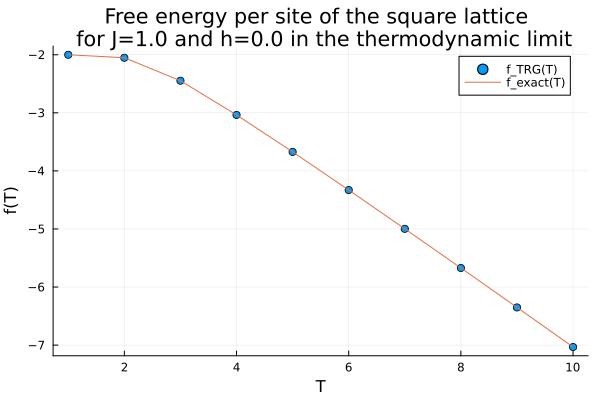

In [ ]:
## Plot of the free energy per site as a function of the temperature

# Value of the model's parameters
T = 1.0
J = 1.0
h = 0.0 # let it equal to 0 (no exact solution with an external field)
maxd = 16
prec = 1e-3

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

f_TRG(t) = TRG_cross_bis(t, J, h, maxd, prec)[2]
y_f_TRG = f_TRG.(T_range)
scatter(T_range, y_f_TRG, 
    label="f_TRG(T)", 
    title="Free energy per site of the square lattice \n for J=$J and h=$h in the thermodynamic limit", 
    xlabel="T", 
    ylabel="f(T)", 
    legend=:topright)

y_f_exact = ising_free_energy_per_site.(T_range, J)
plot!(T_range, y_f_exact, 
    label="f_exact(T)")

#savefig("free_energy_per_site_thD_limit.png")

#### Diference of the free energy per site between TRG results and exact solution vs Temperature (Thermodynamic limit)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.6732717237425655
 
precision = 1.0e-7
 
scale = 1
z = 8.791536623943266
scale = 2
z = 8.060630377855981
scale = 3
z = 7.718886266388247
scale = 4
z = 7.553485656694653
scale = 5
z = 7.472119608777815
scale = 6
z = 7.431765855089581
scale = 7
z = 7.411670777031501
scale = 8
z = 7.401643623180883
scale = 9
z = 7.396635134505896
scale = 10
z = 7.3941321612267235
scale = 11
z = 7.392880992226265
scale = 12
z = 7.39225548712014
scale = 13
z = 7.391942754413645
scale = 14
z = 7.3917863930217935
scale = 15
z = 7.391708213566187
scale = 16
z = 7.39166912414846
scale = 17
z = 7.391649579517114
scale = 18
z = 7.391639807220821
scale = 19
z = 7.39163492107752
scale = 20
z = 7.39163247800708
scale = 21
z = 7.391631256472163
scale = 22
z = 7.3916306457047805
scale = 23
z = 7.391630340321108
scale = 24
z = 7.391630187629277
scale = 25
z = 7.391630111283362
 
final scale = 25
N = 67108864
 
The partition function Z = NaN
The free energy F = NaN
 
Th

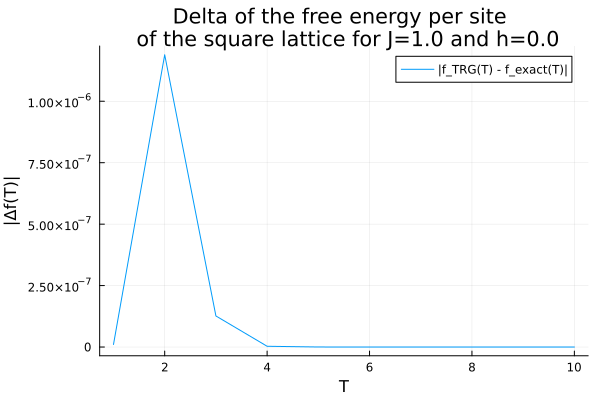

In [ ]:
## Plot of the difference of the free energy per site between the TRG results and the exact solution as a function of the temperature

# Value of the model's parameters
T = 1.0
J = 1.0
h = 0.0 # let it equal to 0 (no exact solution with an external field)
maxd = 16
prec = 1e-7

# Temperature range
T_min = 1
T_max = 10
T_step = 1

T_range = T_min:T_step:T_max

f_TRG(t) = TRG_cross_bis(t, J, h, maxd, prec)[2]
y_f_TRG = f_TRG.(T_range)
y_f_exact = ising_free_energy_per_site.(T_range, J)
y = abs.(y_f_TRG .- y_f_exact)
plot(T_range, y, 
    label="|f_TRG(T) - f_exact(T)|", 
    title="Delta of the free energy per site \n of the square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="|Δf(T)|", 
    legend=:topright)
#savefig("delta_free_energy_per_site.png")

#### Magnetization per site vs Temperature ($L_h \times L_v$ lattice)

T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.9999999950239349
 
precision = 0.001
 
scale = 1
z = 1.3321731668726377e9
 
final scale = 1
N = 4
 
The partition function Z = 3.1495080792077307e36
The free energy F = -8.404030962309722
 
The partition function per site z = 1.3321731668726377e9
The free energy per site f = -2.1010077405774306
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.9999999950239349
 
precision = 0.001
 
scale = 1
z = 1.3058119055044765e9
 
final scale = 1
N = 4
 
The partition function Z = 2.9075185589676744e36
The free energy F = -8.396036333631187
 
The partition function per site z = 1.3058119055044765e9
The free energy per site f = -2.099009083407797
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.9999999950239349
 
precision = 0.001
 
scale = 1
z = 1.3202450279695313e9
 
final scale = 1
N = 4
 
The partition function Z = 3.038212613702432e36
The free energy F = -8.400433273427092
 
The partition function per site z = 1.3202450279695313e9
The fre

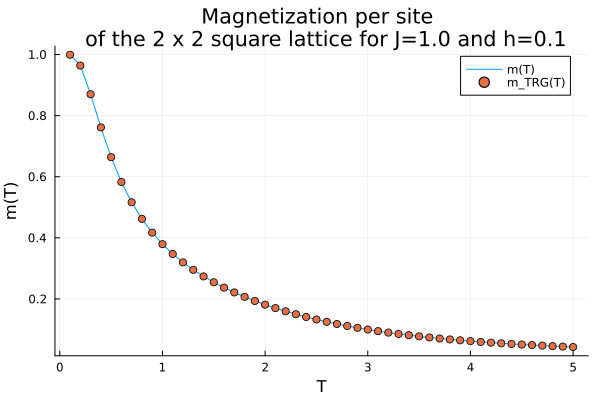

In [ ]:
## Plot of the mean magnetization per site as a function of the temperature

# Value of the model's parameters
T = 1
J= 1.0
h= 0.1
L_h, L_v = 2, 2

maxd = 16
prec = 1e-3

# Temperature range
T_min = 0.1
T_max = 5
T_step = 0.1

T_range = T_min:T_step:T_max

function magnetization_per_site_square(L_h, L_v, T, J, h)
    f(x) = free_energy_per_site_square(L_h, L_v, T, J, x)
    m = -numerical_derivative(f, h)
    return m
end

y_m = magnetization_per_site_square.(L_h, L_v, T_range, J, h)
plot(T_range, y_m, 
    label="m(T)", 
    title="Magnetization per site \n of the $L_h x $L_v square lattice for J=$J and h=$h", 
    xlabel="T", 
    ylabel="m(T)", 
    legend=:topright)

function magnetization_per_site_TRG(L_h, L_v, T, J, h)
    topscale = log2((L_h)*(L_v)) - 1
    f_TRG(x) = TRG_cross_bis(T, J, x, maxd, prec, topscale)[2]
    m = -numerical_derivative(f_TRG, h)
    return m
end

y_m_TRG = magnetization_per_site_TRG.(L_h, L_v, T_range, J, h)
scatter!(T_range, y_m_TRG, 
    label="m_TRG(T)")
#savefig("magnetization_per_site_2x2.png")


#### Magnetization per site vs Temperature (Thermodynamic limit)

In [93]:
## Plot of the mean magnetization per site as a function of the temperature

# Value of the model's parameters
T = 1
J= 1.0
h= 1e-5
T_c = (2/log(1+sqrt(2)))*J/kb

maxd = 16
prec = 1e-7

# Temperature range for TRG
T_min = 0.1
T_max = T_c
T_step = 0.05

# Temperature range for exact solution
T_min_exact = T_min
T_max_exact = 4.5
T_step_exact = 0.01

# D_max list 
D_max_list = [4, 8, 16]

T_range = T_min:T_step:T_max
T_range_exact = T_min_exact:T_step_exact:T_max_exact

y_m_exact = mag_exact.(T_range_exact, J)
plot(T_range_exact, y_m_exact, 
    label="m exact", 
    title="Magnetization per site \n of the square lattice for J=$J and h=0", 
    xlabel="kb T/J", 
    ylabel="m", 
    legend=:topright)
xlims!(min(0, T_min, T_min_exact), max(T_max, T_max_exact))
    

function magnetization_per_site_TRG(T, J, h, maxd)
    f_TRG(x) = TRG_cross_bis(T, J, x, maxd, prec)[2]
    m = -numerical_derivative(f_TRG, h)
    return m
end

for maxd in D_max_list
    y_m_TRG = magnetization_per_site_TRG.(T_range, J, h, maxd)
    scatter!(T_range, y_m_TRG, 
        label="m_TRG for maxd = $maxd")
end 

savefig("m(T)_thD_limit.svg")


T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.9999999950239349
 
precision = 1.0e-7
 
scale = 1
z = 5.769619162954869e8
scale = 2
z = 5.29076422821723e8
scale = 3
z = 5.0664534275595945e8
scale = 4
z = 4.957890258000308e8
scale = 5
z = 4.904484879049867e8
scale = 6
z = 4.8779997218391156e8
scale = 7
z = 4.8648136506152755e8
scale = 8
z = 4.858239624420517e8
scale = 9
z = 4.8549671705596e8
scale = 10
z = 4.85335391011004e8
scale = 11
z = 4.8525894348303807e8
scale = 12
z = 4.852276087821152e8
scale = 13
z = 4.852193613410206e8
scale = 14
z = 4.8521857746919554e8
scale = 15
z = 4.852185665206975e8
scale = 16
z = 4.8521856651664394e8
scale = 17
z = 4.8521856651664394e8
 
final scale = 17
N = 262144
 
The partition function Z = NaN
The free energy F = NaN
 
The partition function per site z = 4.8521856651664394e8
The free energy per site f = -2.000011
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.9999999950239349
 
precision = 1.0e-7
 
scale = 1
z = 5.769619116797909e8
scale = 

Excessive output truncated after 524304 bytes.

3.2796650988351046
scale = 18
z = 3.2796645185276736
scale = 19
z = 3.2796645037152583
 
final scale = 19
N = 1048576
 
The partition function Z = NaN
The free energy F = NaN
 
The partition function per site z = 3.2796645037152583


"c:\\Users\\matth\\Desktop\\Tout\\Dossier\\neel tensor network\\Julia\\m(T)_thD_limit.svg"

#### Diference of the mean magnetization per site between TRG results and exact solution vs Temperature (Thermodynamic limit)

In [98]:
## Plot of the difference of the mean magnetization per site between the TRG results and the exact solution as a function of the temperature

# Value of the model's parameters
T = 1
J= 1.0
h= 1e-5
T_c = (2/log(1+sqrt(2)))*J/kb

maxd = 16
prec = 1e-7

# Temperature range for TRG
T_min = 1.5
T_max = T_c
T_step = 0.05

# D_max list 
D_max_list = [4, 8, 16]

T_range = T_min:T_step:T_max

y_m_exact = mag_exact.(T_range, J)

function magnetization_per_site_TRG(T, J, h, maxd)
    f_TRG(x) = TRG_cross_bis(T, J, x, maxd, prec)[2]
    m = -numerical_derivative(f_TRG, h)
    return m
end

y_m_TRG = magnetization_per_site_TRG.(T_range, J, h, D_max_list[1])
diff_m = abs.(y_m_TRG .- y_m_exact)
plot(T_range, diff_m, 
    label="|m_TRG(T) - m_exact(T)| for maxd = 4")

for maxd in D_max_list[2:end]
    y_m_TRG = magnetization_per_site_TRG.(T_range, J, h, maxd)
    diff_m = abs.(y_m_TRG .- y_m_exact)
    plot!(T_range, diff_m, 
        label="|m_TRG(T) - m_exact(T)| for maxd = $maxd")
end 

savefig("diff_m(T)_thD_limit.png")


T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.3636202141582786
 
precision = 1.0e-7
 
scale = 1
z = 4.543805189155872
scale = 2
z = 4.160265078343056
scale = 3
z = 3.9839946029864417
scale = 4
z = 3.8985800662316192
scale = 5
z = 3.8565829554398863
scale = 6
z = 3.8357551208593383
scale = 7
z = 3.825383465970213
scale = 8
z = 3.8202081796351264
scale = 9
z = 3.8176232010198388
scale = 10
z = 3.816331444432126
scale = 11
z = 3.815685883422414
scale = 12
z = 3.815363450283232
scale = 13
z = 3.8152028543881977
scale = 14
z = 3.8151237614055153
scale = 15
z = 3.815086481707356
scale = 16
z = 3.815071491431212
scale = 17
z = 3.8150677460595106
scale = 18
z = 3.815067425686579
scale = 19
z = 3.815067421999149
 
final scale = 19
N = 1048576
 
The partition function Z = NaN
The free energy F = NaN
 
The partition function per site z = 3.815067421999149
The free energy per site f = -2.0084375061754245
T_c = 2.269185314213022
(alpha_c-alpha)/alpha_c = 0.3636202141582786
 
precision = 1.0e-

"c:\\Users\\matth\\Desktop\\Tout\\Dossier\\neel tensor network\\Julia\\diff_m(T)_thD_limit.png"

#### Magnetization per site vs alpha (Thermodynamic limit)

In [100]:
## Plot of the mean magnetization per site as a function of (α_c - α)/α_c

# Value of the model's parameters
J= 1.0
h= 1e-7

prec = 1e-10

# Ratio range
ratio_min = 1e-5
ratio_max = 0.99
nb_steps = 10

ratio_range = maprange(log, ratio_min, ratio_max, length=nb_steps)

# TRG max bond dimensions to explore
maxd_list = [8, 16, 20, 24, 28, 32]

T_c = (2/log(1+sqrt(2)))*J/kb

function magnetization_per_site_TRG(T, J, h, maxd)
    f_TRG(x) = TRG_cross(T, J, x, maxd, prec)[2]
    m = -numerical_derivative(f_TRG, h)
    return m
end

# f_alpha: given temperature t, compute alpha(t)
f_alpha(t) = exp(-2 * J / (kb * t))
# finv_alpha: given alpha, recover the corresponding temperature-like parameter
finv_alpha(a) = -2 * J / (kb * log(a))

# Critical alpha value corresponding to T_c.
alpha_c = f_alpha(T_c)

# ratio function: normalized difference between alpha_c and a given alpha.
ratio(a) = (alpha_c - a) / alpha_c
# Inverse ratio: recovers an "alpha" value from a normalized value.
inv_ratio(r) = alpha_c * (1 - r)

# File & Data
const datafile = "magnetization_data.jld2"
results = Dict{String, Any}()

# Load existing results if present
if isfile(datafile)
    @info "Loading existing results from disk"
    @load datafile results
else
    @info "No data file found, initializing fresh results"
end

# Always compute or update the "exact" part
results["ratio_range"] = ratio_range
results["exact"] = mag_exact.(finv_alpha.(inv_ratio.(ratio_range)), J)

# Compute missing TRG data
for maxd in maxd_list
    key = "TRG_$(maxd)"
    if haskey(results, key)
        @info "Found cached TRG result for maxd = $maxd"
    else
        @info "Computing TRG for maxd = $maxd..."
        y_TRG = magnetization_per_site_TRG.(finv_alpha.(inv_ratio.(ratio_range)), J, h, maxd)
        results[key] = y_TRG
        @save datafile results  # Save after each new computation
    end
end

# Plot everything
plot(ratio_range, results["exact"],
    label = "Exact m",
    title = "Magnetization per site (J = $J, h = 0)",
    xlabel = "(α_c - α) / α_c",
    ylabel = "m",
    legend = :bottomright,
    xscale = :log10,
    yscale = :log10,
    minorgrid = true)

for maxd in maxd_list
    key = "TRG_$(maxd)"
    scatter!(ratio_range, results[key], label = "TRG with maxd = $maxd")
end

savefig("magnetization.svg")

[ Info: Loading existing results from disk
[ Info: Found cached TRG result for maxd = 8
[ Info: Found cached TRG result for maxd = 16
[ Info: Found cached TRG result for maxd = 20
[ Info: Found cached TRG result for maxd = 24
[ Info: Found cached TRG result for maxd = 28
[ Info: Found cached TRG result for maxd = 32


"c:\\Users\\matth\\Desktop\\Tout\\Dossier\\neel tensor network\\Julia\\magnetization.svg"